# Feature importances

This notebook calculates **permutation importance** for each input of each of the 4 identified models:

- CNN with dropout (CNN "A")
- CNN without dropout (CNN "B")
- MLP single-pixel model
- RF single-pixel model

**Permutation Importance** of a feature is calculated by *permuting* the values of the feature and measuring the change
in accuracy from when no features are permuted. The idea is more important features will reduce the model's accuracy
more than unimportant features. We calculate permutation importance using the test dataset (2021), which was unseen by
all models during training and hyperparameter tuning.

This notebook requires keeping a *lot* of data in memory and can take several hours to run, so be warned.

In [2]:
from pathlib import Path
import tensorflow as tf
from keras import Model
import xarray as xr
import keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import xarray as xr
from plot_utils import cblind_cmap
from matplotlib.colors import ListedColormap, BoundaryNorm, LogNorm
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import joblib
from plot_utils import PHASE_TO_NUM_MAP, PHASE_MAP
from tqdm.notebook import tqdm

PHASE_NUMS = [1, 2, 3, 4, 5, 6, 7]  # ignore cloudy and unknown pixels for accuracy
PHASES = [PHASE_MAP[i] for i in PHASE_NUMS]

2024-11-11 17:16:41.893581: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def add_argmax(model: Model) -> Model:
    """Adds an argmax layer to the model to ensure outputs are 0-7 instead of an array
    with length 7. This makes it easier to compare with the y_test labels."""
    argmax_layer = keras.layers.Lambda(lambda x: tf.argmax(x, axis=-1), name='argmax_layer')
    return Model(inputs=model.input, outputs=argmax_layer(model.output))

In [3]:
# load models
cnn_A: Model = add_argmax(keras.models.load_model("../processing/models/cnn.20240429.213223.h5"))  # type: ignore
cnn_B: Model = add_argmax(keras.models.load_model("../processing/models/cnn.20240501.090456.h5"))  # type: ignore
mlp: MLPClassifier = joblib.load("../processing/models/mlp_1600k.20240514.052837.joblib")
rf: RandomForestClassifier = joblib.load("../processing/models/rf_1600k.20240514.033147.joblib")

In [4]:
# _ = keras.utils.plot_model(
#     cnn_A,
#     to_file="cnn_A.png",
#     show_shapes=True,
#     show_dtype=False,
#     show_layer_names=False,
#     rankdir="TB",
#     # expand_nested=False,
#     dpi=200,
#     show_layer_activations=False,
#     # show_trainable=False,
# )

In [5]:
cnn_feature_vars = [  # The CNNs include 'cloud_flag' as a feature. single-pixel models do not.
    "cloud_flag",
    "temp",
    "mpl_backscatter",
    "mpl_linear_depol_ratio",
    "reflectivity",
    "radar_linear_depolarization_ratio",
    "spectral_width",
    "mean_doppler_velocity",
    "mwrret1liljclou_be_lwp",
]

mlp.feature_names_in_  # RF features are the same as this, but not scaled

array(['temp', 'mpl_backscatter', 'mpl_linear_depol_ratio',
       'reflectivity', 'radar_linear_depolarization_ratio',
       'spectral_width', 'mean_doppler_velocity',
       'mwrret1liljclou_be_lwp'], dtype=object)

In [6]:
def make_rf_pred(df: pd.DataFrame) -> pd.Series:
    return pd.Series(rf.predict(df), index=df.index, name="rf_pred").map(PHASE_TO_NUM_MAP)


def make_mlp_pred(X: np.ndarray) -> np.ndarray:
    """From the input tensor/array, makes predictions using the MLP model and returns
    an array with shape (samples, 128, 384). X should have shape (samples, 128, 384, 9)"""
    data = X.reshape((-1, 384, 9)).reshape((-1, 9))
    df = pd.DataFrame(data, columns=cnn_feature_vars)
    
    mlp_out = pd.Series(0, index=df.index)
    cloudy = df[df["cloud_flag"] == 1]
    pred = pd.Series(mlp.predict(cloudy[mlp.feature_names_in_]))
    pred = pred.map(PHASE_TO_NUM_MAP)  # output is labels (eg 'ice'). We want numbers so we can compare with y_test
    mlp_out.iloc[cloudy.index] = pred

    return mlp_out.values.reshape((-1, 128, 384))  # reshape to match y_test


## Calculating Feature Importances

This section is for calculating the feature importances for each model. This can easily take several hours, so the
outputs are written to `src/analysis/data/importance/` as parquet files and the code for making predictions only runs if
the output importance files don't exist. These files are pretty small, so they are committed to the repo. To rerun this
section from scratch (i.e., to reproduce the results) either move them somewhere else or delete them.

In [ ]:
# Permutation importance should be computed on the test dataset, which was unseen by the
# model during training and hyperparameter tuning. The test data is from 2021 at NSA C1.
X_test = np.load("../preprocessing/data/cnn_inputs/X_test.npy")
y_test = np.squeeze(np.load("../preprocessing/data/cnn_inputs/y_test.npy"))  # (S, 128, 384, 1) --> (S, 128, 384)
y_flat = y_test.ravel()  # flatten to 1D array (S x 128 x 2384)
print(f"{X_test.shape = }")
print(f"{y_test.shape = }")

In [ ]:
models = {"cnnA": cnn_A, "cnnB": cnn_B}

for model_label, model in models.items():

    PHASE_IMPORTANCE_PATH = Path(f"./data/importance/{model_label}_phase_importances.parquet")
    PHASE_HEIGHT_IMPORTANCE_PATH = Path(f"./data/importance/{model_label}_phase_height_importance.parquet")

    if not PHASE_IMPORTANCE_PATH.exists():
        
        pred = model.predict(X_test, verbose=0)  # type: ignore
        y_pred = pred.ravel()

        PHASE_IMPORTANCE_PATH.parent.mkdir(parents=True, exist_ok=True)

        phase_idxs = {phase_id: np.where(y_flat == phase_id) for phase_id in PHASE_NUMS}
        phase_values = {phase_id: (y_test == phase_id) for phase_id in PHASE_NUMS}

        def phase_acc_scores(y_pred):
            scores: dict[str, float] = {}
            for phase_id, idxs in phase_idxs.items():
                if not len(idxs[0]):
                    scores[PHASE_MAP[phase_id]] = np.nan
                    continue
                scores[PHASE_MAP[phase_id]] = (y_pred[idxs] == phase_id).mean()
            scores["avg"] = np.nanmean(list(scores.values()))  # type: ignore
            return scores


        def phase_acc_height_scores(y_true, y_pred):
            # y_true/pred should have shape (samples, 128, 384)
            matches = (y_true == y_pred)
            scores = pd.DataFrame({"overall": matches.mean(axis=(0,1))})
            for phase_id, of_phase_type in phase_values.items():
                numerator = (matches & of_phase_type).sum(axis=(0,1))
                denominator = of_phase_type.sum(axis=(0,1))
                acc_for_phase = np.full_like(numerator, fill_value=np.nan, dtype=float)
                np.divide(numerator, denominator, out=acc_for_phase, where=denominator>100)
                scores[PHASE_MAP[phase_id]] = acc_for_phase
            scores["overall"] = matches.mean(axis=(0,1))
            return scores


        permuted_scores = {}  # dict of feature_var:dict[phase:]
        permuted_height_scores = {}  # dict of feature_var:dict[phase:]
        # other_height_metrics = {}  # dict of feature_var:sklearn.classification_report

        feature_vars = [
            "cloud_flag",
            "temp",
            "mpl_backscatter",
            "mpl_linear_depol_ratio",
            "reflectivity",
            "radar_linear_depolarization_ratio",
            "spectral_width",
            "mean_doppler_velocity",
            "mwrret1liljclou_be_lwp",
        ]
        assert len(feature_vars) == X_test.shape[-1]
        for i, feature_name in enumerate(tqdm(feature_vars[1:])):
            i = i+1  # skip cloud_flag

            # Predict on permuted feature column
            X_permuted = X_test.copy()
            np.random.shuffle(X_permuted[:, :, :, i])
            y_pred_permuted = model.predict(X_permuted, verbose=0)  # type: ignore

            # Measure accuracy by phase and by phase/height
            permuted_scores[feature_name] = phase_acc_scores(y_pred_permuted.ravel())
            permuted_height_scores[feature_name] = phase_acc_height_scores(y_true=y_test, y_pred=y_pred_permuted)


        phase_baseline = phase_acc_scores(y_pred)
        phase_height_baseline = phase_acc_height_scores(y_test, pred)


        # phase importances
        phase_importance_df = pd.DataFrame.from_dict(permuted_scores, orient="columns")
        phase_importance_df = phase_importance_df.reset_index(names="phase").melt(id_vars='phase', var_name='feature', value_name='acc').set_index("phase")
        phase_importance_df["importance"] = phase_importance_df.reset_index().apply(lambda row: phase_baseline[row["phase"]] - row["acc"], axis=1).set_axis(phase_importance_df.index)
        phase_importance_df.to_parquet(PHASE_IMPORTANCE_PATH)

        # phase-height importances
        phase_height_dfs = {}
        for phase in list(PHASES) + ["overall"]:
            df = pd.DataFrame({k: v[phase] for k, v in permuted_height_scores.items()})
            df = -df.subtract(phase_height_baseline[phase], axis=0)  # baseline-permuted = score
            df = df.reset_index(names=["height_idx"])
            df = df.melt(id_vars=["height_idx"], value_name="importance")
            df["phase"] = phase
            phase_height_dfs[phase] = df
        phase_height_importance_df = pd.concat(phase_height_dfs.values())
        phase_height_importance_df["height"] = 0.16 + (0.03 * phase_height_importance_df.pop("height_idx"))  # type: ignore
        phase_height_importance_df.to_parquet(PHASE_HEIGHT_IMPORTANCE_PATH)

    else:
        phase_importance_df = pd.read_parquet(PHASE_IMPORTANCE_PATH)
        phase_height_importance_df = pd.read_parquet(PHASE_HEIGHT_IMPORTANCE_PATH)
            

In [37]:
PHASE_IMPORTANCE_PATH = Path("./data/importance/mlp_phase_importances.parquet")
PHASE_HEIGHT_IMPORTANCE_PATH = Path("./data/importance/mlp_phase_height_importance.parquet")

if not PHASE_IMPORTANCE_PATH.exists():
    
    pred = make_mlp_pred(X_test)  # BASELINE
    y_pred = pred.ravel()

    PHASE_IMPORTANCE_PATH.parent.mkdir(parents=True, exist_ok=True)

    phase_idxs = {phase_id: np.where(y_flat == phase_id) for phase_id in PHASE_NUMS}
    phase_values = {phase_id: (y_test == phase_id) for phase_id in PHASE_NUMS}

    def phase_acc_scores(y_pred):
        scores: dict[str, float] = {}
        for phase_id, idxs in phase_idxs.items():
            if not len(idxs[0]):
                scores[PHASE_MAP[phase_id]] = np.nan
                continue
            scores[PHASE_MAP[phase_id]] = (y_pred[idxs] == phase_id).mean()
        scores["avg"] = np.nanmean(list(scores.values()))  # type: ignore
        return scores


    def phase_acc_height_scores(y_true, y_pred):
        # y_true/pred should have shape (samples, 128, 384)
        matches = (y_true == y_pred)
        scores = pd.DataFrame({"overall": matches.mean(axis=(0,1))})
        for phase_id, of_phase_type in phase_values.items():
            numerator = (matches & of_phase_type).sum(axis=(0,1))
            denominator = of_phase_type.sum(axis=(0,1))
            acc_for_phase = np.full_like(numerator, fill_value=np.nan, dtype=float)
            np.divide(numerator, denominator, out=acc_for_phase, where=denominator>100)
            scores[PHASE_MAP[phase_id]] = acc_for_phase
        scores["overall"] = matches.mean(axis=(0,1))
        return scores


    permuted_scores = {}  # dict of feature_var:dict[phase:]
    permuted_height_scores = {}  # dict of feature_var:dict[phase:]
    # other_height_metrics = {}  # dict of feature_var:sklearn.classification_report

    feature_vars = [
        "cloud_flag",
        "temp",
        "mpl_backscatter",
        "mpl_linear_depol_ratio",
        "reflectivity",
        "radar_linear_depolarization_ratio",
        "spectral_width",
        "mean_doppler_velocity",
        "mwrret1liljclou_be_lwp",
    ]
    assert len(feature_vars) == X_test.shape[-1]
    for i, feature_name in enumerate(tqdm(feature_vars[1:])):
        i = i+1  # skip cloud_flag

        # Predict on permuted feature column
        X_permuted = X_test.copy()
        np.random.shuffle(X_permuted[:, :, :, i])
        y_pred_permuted = make_mlp_pred(X_permuted)

        # Measure accuracy by phase and by phase/height
        permuted_scores[feature_name] = phase_acc_scores(y_pred_permuted.ravel())
        permuted_height_scores[feature_name] = phase_acc_height_scores(y_true=y_test, y_pred=y_pred_permuted)


    phase_baseline = phase_acc_scores(y_pred)
    phase_height_baseline = phase_acc_height_scores(y_test, pred)


    # phase importances
    phase_importance_df = pd.DataFrame.from_dict(permuted_scores, orient="columns")
    phase_importance_df = phase_importance_df.reset_index(names="phase").melt(id_vars='phase', var_name='feature', value_name='acc').set_index("phase")
    phase_importance_df["importance"] = phase_importance_df.reset_index().apply(lambda row: phase_baseline[row["phase"]] - row["acc"], axis=1).set_axis(phase_importance_df.index)
    phase_importance_df.to_parquet(PHASE_IMPORTANCE_PATH)

    # phase-height importances
    phase_height_dfs = {}
    for phase in list(PHASES) + ["overall"]:
        df = pd.DataFrame({k: v[phase] for k, v in permuted_height_scores.items()})
        df = -df.subtract(phase_height_baseline[phase], axis=0)  # baseline-permuted = score
        df = df.reset_index(names=["height_idx"])
        df = df.melt(id_vars=["height_idx"], value_name="importance")
        df["phase"] = phase
        phase_height_dfs[phase] = df
    phase_height_importance_df = pd.concat(phase_height_dfs.values())
    phase_height_importance_df["height"] = 0.16 + (0.03 * phase_height_importance_df.pop("height_idx"))  # type: ignore
    phase_height_importance_df.to_parquet(PHASE_HEIGHT_IMPORTANCE_PATH)

else:
    phase_importance_df = pd.read_parquet(PHASE_IMPORTANCE_PATH)
    phase_height_importance_df = pd.read_parquet(PHASE_HEIGHT_IMPORTANCE_PATH)
        

In [ ]:
PHASE_IMPORTANCE_PATH = Path("./data/importance/rf_phase_importances.parquet")
PHASE_HEIGHT_IMPORTANCE_PATH = Path("./data/importance/rf_phase_height_importance.parquet")

if not PHASE_IMPORTANCE_PATH.exists():

    # load data and get X & y test set
    ds = xr.open_mfdataset("../preprocessing/data/raw/nsathermocldphaseC1.c1.2021*.nc")[list(rf.feature_names_in_) + ["cloud_flag", "cloud_phase_mplgr"]]
    df = ds.to_dataframe().fillna(0)
    df = df[df["cloud_flag"] == 1]
    ds.close()
    del ds
    df_known_phase = df[~df["cloud_phase_mplgr"].isin([0.0, 8.0])]
    X_test = df_known_phase[rf.feature_names_in_]
    y_test = df_known_phase["cloud_phase_mplgr"]
    
    y_pred = make_rf_pred(X_test)  # BASELINE

    PHASE_IMPORTANCE_PATH.parent.mkdir(parents=True, exist_ok=True)

    phase_idxs = {phase_id: np.where(y_test == phase_id) for phase_id in PHASE_NUMS}
    phase_values = {phase_id: (y_test == phase_id) for phase_id in PHASE_NUMS}

    def phase_acc_scores(y_pred):
        scores: dict[str, float] = {}
        for phase_id, idxs in phase_values.items():
            if not idxs.any() or idxs.sum() < 100:
                scores[PHASE_MAP[phase_id]] = np.nan
                continue
            scores[PHASE_MAP[phase_id]] = (y_pred[idxs] == phase_id).mean()
        scores["avg"] = np.nanmean(list(scores.values()))  # type: ignore
        return scores

    def phase_acc_height_scores(y_pred):
        matches = pd.Series((y_test == y_pred), name="correct")
        scores = pd.DataFrame(matches.reset_index().groupby("height").agg(overall=pd.NamedAgg(column="correct", aggfunc="mean")))
        for phase_id, of_phase_type in phase_values.items():
            numerator = (matches & of_phase_type).sum()
            denominator = of_phase_type.sum()
            acc_for_phase = np.full_like(numerator, fill_value=np.nan, dtype=float)
            np.divide(numerator, denominator, out=acc_for_phase, where=denominator>100)
            scores[PHASE_MAP[phase_id]] = acc_for_phase
        return scores


    permuted_scores = {}  # dict of feature_var:dict[phase:]
    permuted_height_scores = {}  # dict of feature_var:dict[phase:]

    for i, feature_name in enumerate(tqdm(rf.feature_names_in_)):
        # Predict on permuted feature column
        X_permuted = X_test.copy()
        X_permuted[feature_name] = X_permuted[feature_name].sample(frac=1).values
        y_pred_permuted = make_rf_pred(X_permuted)

        # Measure accuracy by phase and by phase/height
        permuted_scores[feature_name] = phase_acc_scores(y_pred_permuted.ravel())
        permuted_height_scores[feature_name] = phase_acc_height_scores(y_pred=y_pred_permuted)

    phase_baseline = phase_acc_scores(y_pred)
    phase_height_baseline = phase_acc_height_scores(y_pred)

    # phase importances
    phase_importance_df = pd.DataFrame.from_dict(permuted_scores, orient="columns")
    phase_importance_df = phase_importance_df.reset_index(names="phase").melt(id_vars='phase', var_name='feature', value_name='acc').set_index("phase")
    phase_importance_df["importance"] = phase_importance_df.reset_index().apply(lambda row: phase_baseline[row["phase"]] - row["acc"], axis=1).set_axis(phase_importance_df.index)
    phase_importance_df.to_parquet(PHASE_IMPORTANCE_PATH)

    # phase-height importances
    phase_height_dfs = {}
    for phase in list(PHASES) + ["overall"]:
        df = pd.DataFrame({k: v[phase] for k, v in permuted_height_scores.items()})
        df = -df.subtract(phase_height_baseline[phase], axis=0)  # baseline-permuted = score
        df = df.reset_index(names=["height_idx"])
        df = df.melt(id_vars=["height_idx"], value_name="importance")
        df["phase"] = phase
        phase_height_dfs[phase] = df
    phase_height_importance_df = pd.concat(phase_height_dfs.values())
    phase_height_importance_df["height"] = 0.16 + (0.03 * phase_height_importance_df.pop("height_idx"))  # type: ignore
    phase_height_importance_df.to_parquet(PHASE_HEIGHT_IMPORTANCE_PATH)

else:
    phase_importance_df = pd.read_parquet(PHASE_IMPORTANCE_PATH)
    phase_height_importance_df = pd.read_parquet(PHASE_HEIGHT_IMPORTANCE_PATH)

## Visualizing Feature Importances

This section contains the code for plotting the importances of the various models.

In [3]:
p_i_files = sorted(Path("data/importance/").glob("*_phase_importances.parquet"))
p_h_i_files = sorted(Path("data/importance/").glob("*_phase_height_importance.parquet"))

feature_name_map = {
    "temp": r"T ($\degree C$)",
    "mpl_backscatter": r"MPL $\beta$",
    "mpl_linear_depol_ratio": "MPL Dep",
    "reflectivity": "$Z_e$ (dBZ)",
    "radar_linear_depolarization_ratio": "Radar Dep",
    "spectral_width": "W (m/s)",
    "mean_doppler_velocity": "MDV (m/s)",
    "mwrret1liljclou_be_lwp": "LWP (g/$m^2$)",
}

_p_i_dfs = []
for file in p_i_files:
    key = file.name.split("_")[0]
    df = pd.read_parquet(file)
    df["model"] = key
    _p_i_dfs.append(df)
p_i_df = pd.concat(_p_i_dfs)
p_i_df["feature"] = p_i_df["feature"].map(feature_name_map)

_p_h_i_dfs = []
for file in p_h_i_files:
    key = file.name.split("_")[0]
    df = pd.read_parquet(file)
    df["model"] = key
    _p_h_i_dfs.append(df)
p_h_i_df = pd.concat(_p_h_i_dfs)
p_h_i_df["variable"] = p_h_i_df["variable"].map(feature_name_map)

In [4]:
# average by phase & variable across models
_p_i_phase_feature_df = p_i_df.reset_index().groupby(["phase", "feature"]).agg(importance=pd.NamedAgg("importance", "mean"), acc=pd.NamedAgg("acc", "mean")).reset_index().set_index("phase")
_p_i_phase_feature_df["model"] = "avg"
p_i_df = pd.concat([p_i_df, _p_i_phase_feature_df])
p_i_df

,feature,acc,importance,model
phase,,,,
liquid,T ($\degree C$),0.634770,0.016828,cnnA
ice,T ($\degree C$),0.965612,0.025751,cnnA
mixed,T ($\degree C$),0.558346,0.074858,cnnA
drizzle,T ($\degree C$),0.180685,0.363496,cnnA
liq_driz,T ($\degree C$),0.224538,0.435818,cnnA
...,...,...,...,...
snow,MPL $\beta$,0.942381,0.000719,avg
snow,MPL Dep,0.941335,0.001765,avg
snow,Radar Dep,0.815026,0.128074,avg


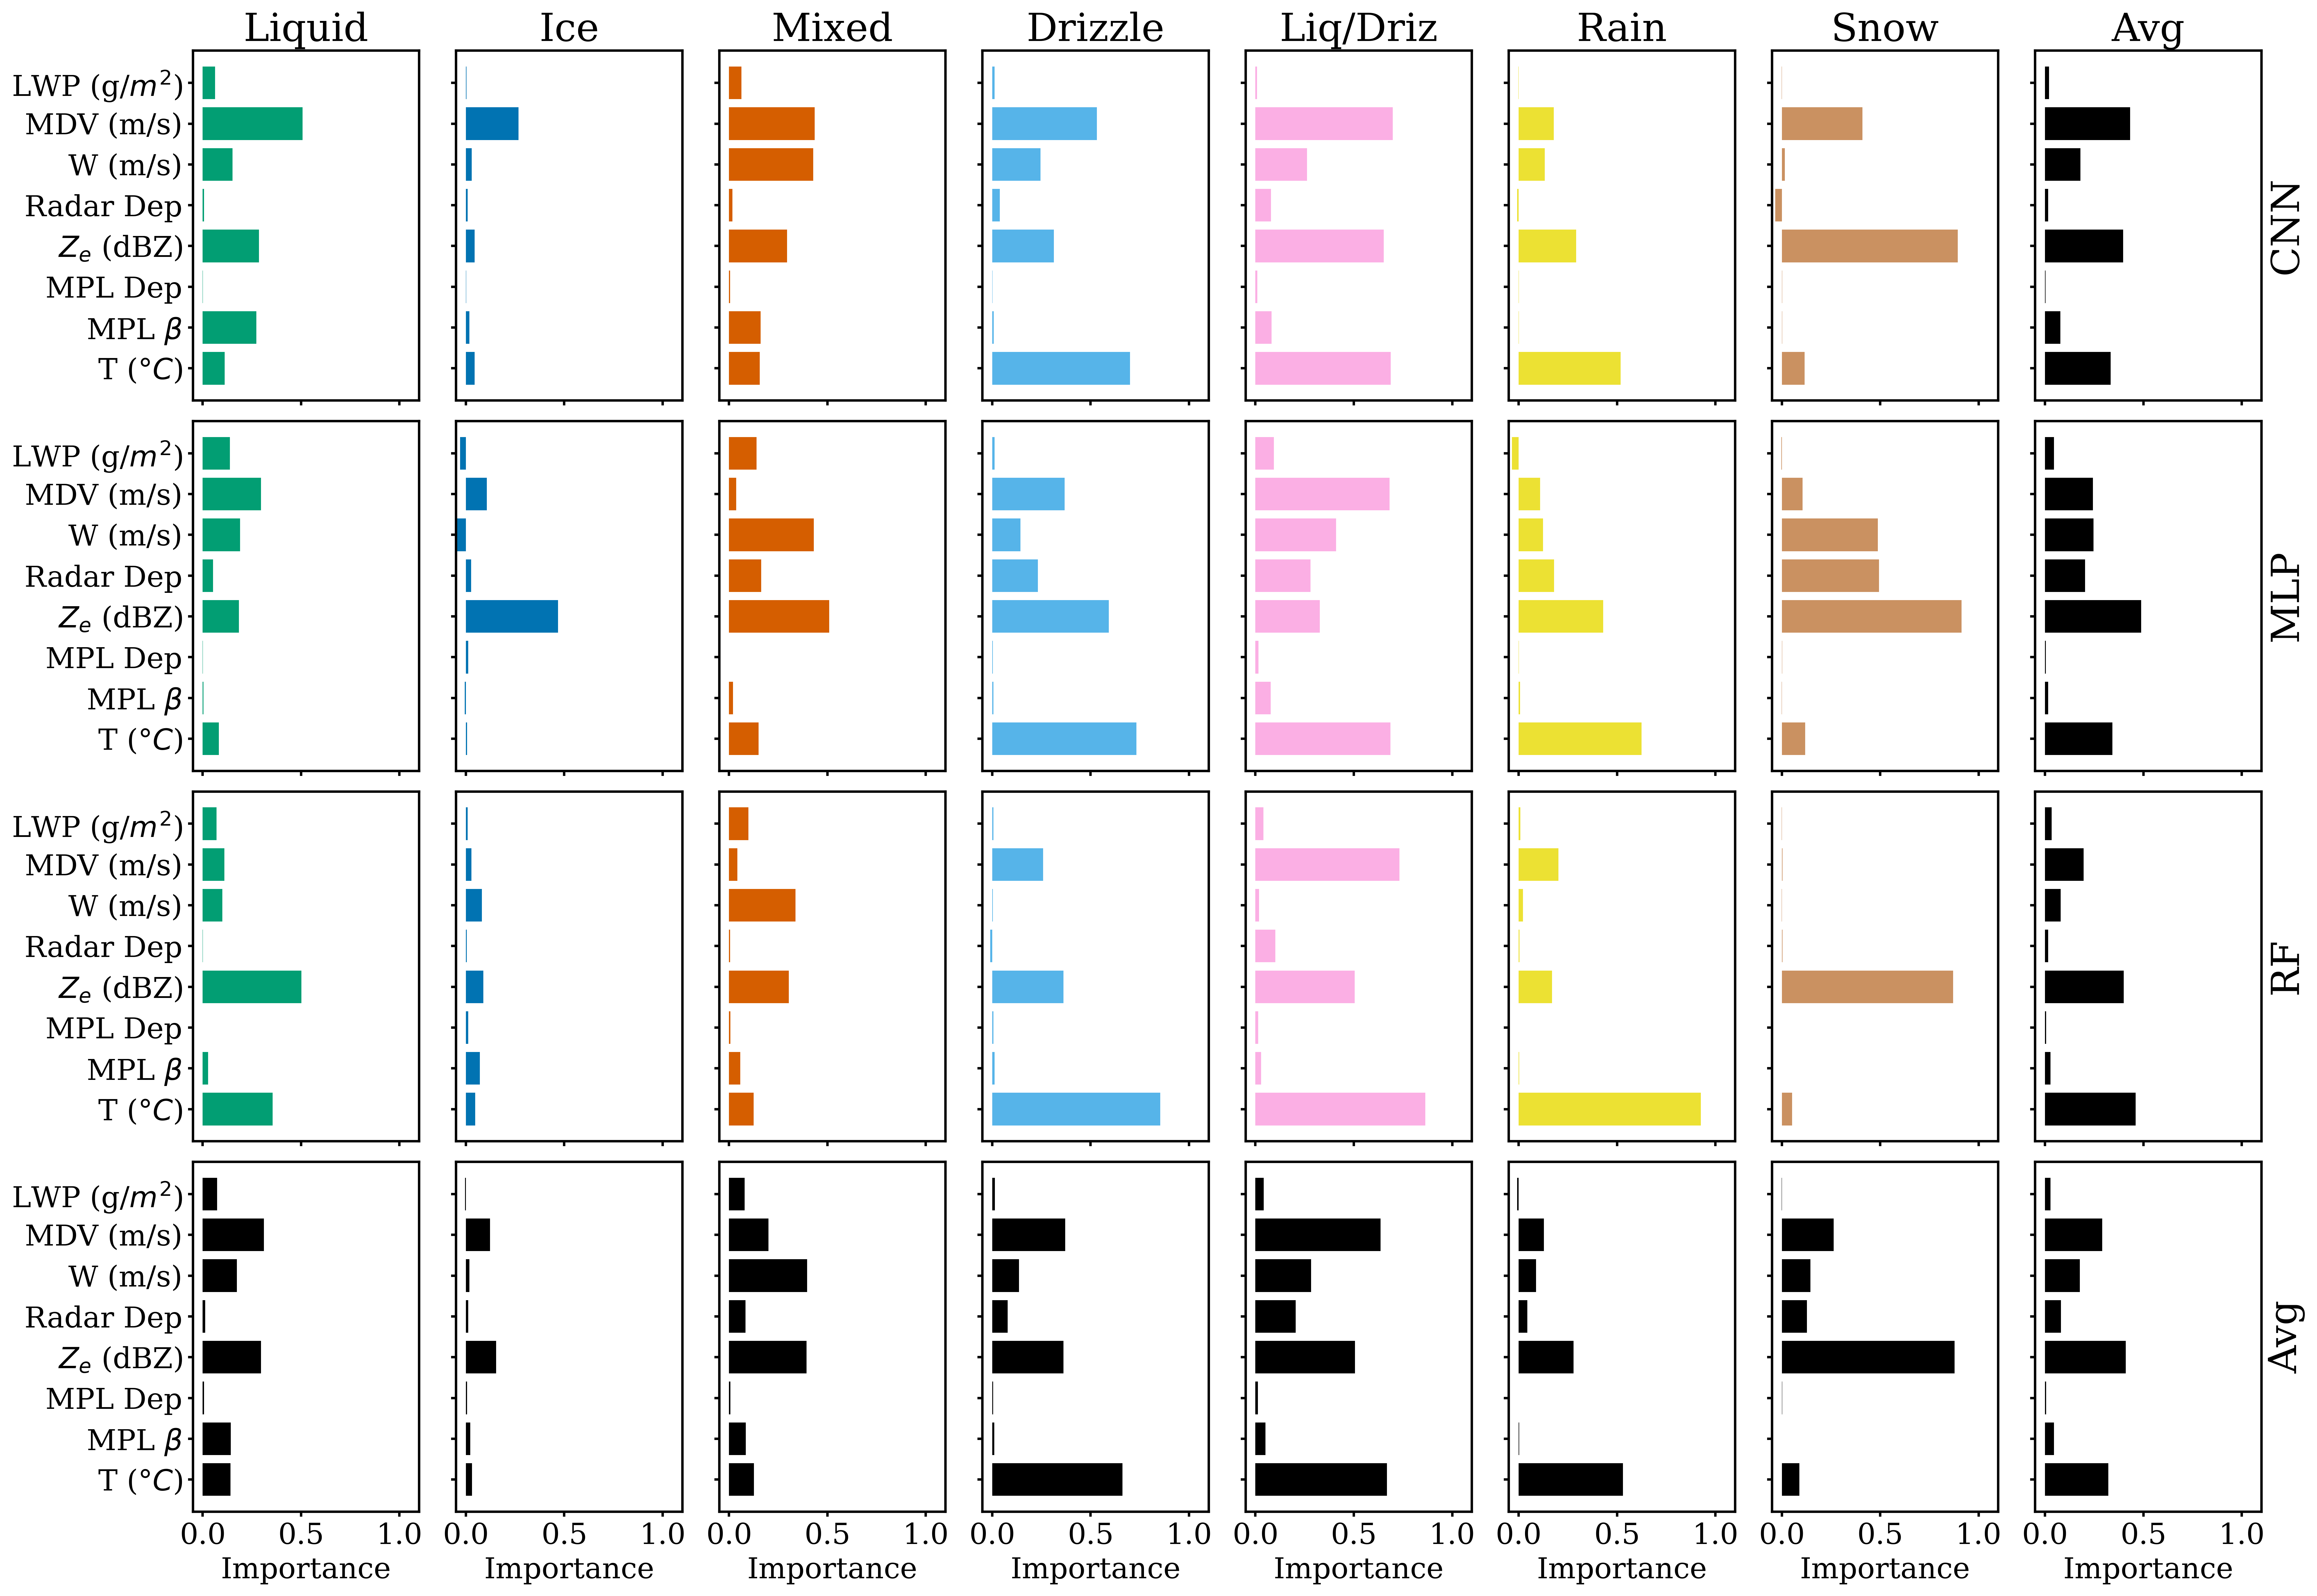

In [7]:
phases = {
    "liquid": "Liquid", 
    "ice": "Ice", 
    "mixed": "Mixed", 
    "drizzle": "Drizzle", 
    "liq_driz": "Liq/Driz", 
    "rain": "Rain", 
    "snow": "Snow", 
    "avg": "Avg",
}
models = {
    # "cnnA": "CNN A",
    "cnnB": "CNN",
    "mlp": "MLP",
    "rf": "RF",
    "avg": "Avg",
}
cmap = cblind_cmap.copy()
cmap["avg"] = "black"

df = p_i_df.reset_index()

with plt.style.context("style.mplstyle"):
    fig, axes = plt.subplots(len(models), len(phases), figsize=(20, 15), sharey=True, sharex=True)
    for i, model in enumerate(models):
        for j, phase in enumerate(phases):
            ax = axes[i, j]
            data_to_plot = df[(df['model'] == model) & (df['phase'] == phase)]
            if not data_to_plot.empty:
                ax.barh(data_to_plot['feature'], data_to_plot['importance'], color=cmap[phase] if model != "avg" else "black")
                ax.set_xlim([-0.05, 1.1])  # Adjust according to your data range
                ax.xaxis.set_ticks([0.0, 0.5, 1.0])
                ax.tick_params(axis='both', which='major', labelsize=18)

    # Set Model Labels
    j = len(phases) - 1
    for i, model in enumerate(models.values()):
        ax = axes[i, j]
        ax.yaxis.set_label_position("right")
        ax.set_ylabel(model, fontsize=24)

    # Set Phase Labels
    i = 0
    for j, phase in enumerate(phases.values()):
        ax = axes[i, j]
        ax.set_title(phase, fontsize=24)

    # Set Importance X Label
    i = len(models) - 1
    for j in range(len(phases)):
        ax = axes[i, j]
        ax.set_xlabel("Importance", fontsize=18)



    # Set common labels
    # fig.suptitle('Feature Importance by Model and Phase', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    fig.savefig("figures/all_importances.png")
    plt.show()

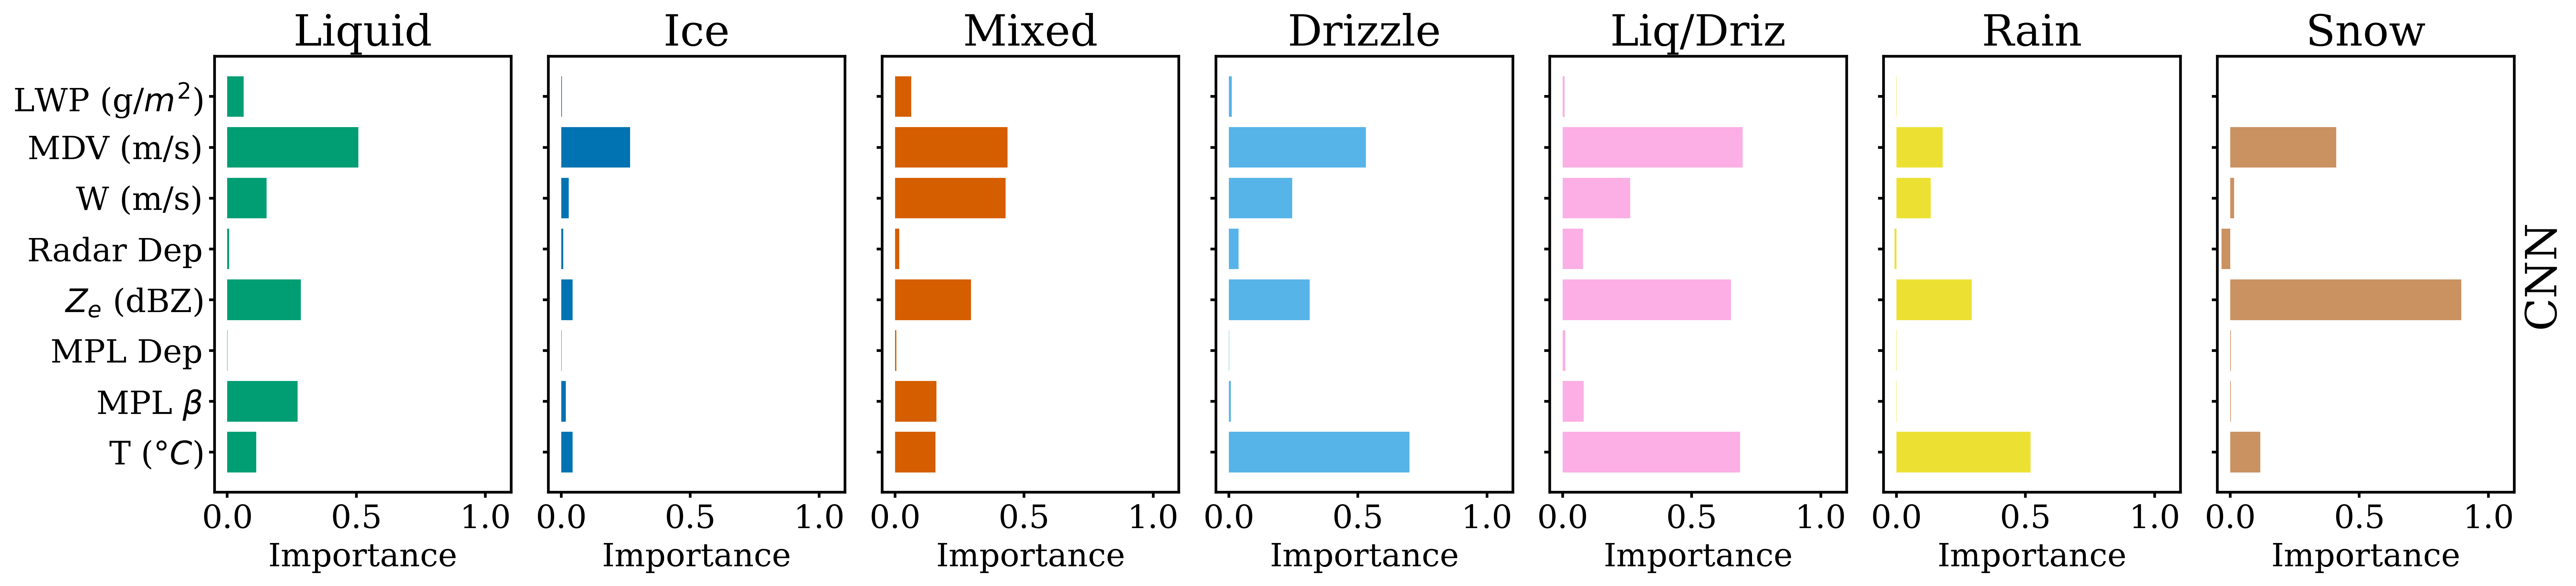

In [12]:
phases = {
    "liquid": "Liquid", 
    "ice": "Ice", 
    "mixed": "Mixed", 
    "drizzle": "Drizzle", 
    "liq_driz": "Liq/Driz", 
    "rain": "Rain", 
    "snow": "Snow",
    # "avg": "Avg",
}
model, model_label = "cnnB", "CNN"
cmap = cblind_cmap.copy()
cmap["avg"] = "black"

df = p_i_df.reset_index()

with plt.style.context("style.mplstyle"):
    fig, axes = plt.subplots(1, len(phases), figsize=(20, 5), sharey=True)
    for j, phase in enumerate(phases):
        ax = axes[j]
        data_to_plot = df[(df['model'] == model) & (df['phase'] == phase)]
        if not data_to_plot.empty:
            ax.barh(data_to_plot['feature'], data_to_plot['importance'], color=cmap[phase] if model != "avg" else "black")
            ax.set_xlim([-0.05, 1.1])
            ax.xaxis.set_ticks([0.0, 0.5, 1.0])
            ax.tick_params(axis='both', which='major', labelsize=18)

    # Set Model Labels
    ax = axes[-1]
    ax.yaxis.set_label_position("right")
    ax.set_ylabel(model_label, fontsize=24)

    for j, phase in enumerate(phases.values()):
        ax = axes[j]
        ax.set_title(phase, fontsize=24)
        ax.set_xlabel("Importance", fontsize=18)


    # fig.suptitle('Feature Importance by Model and Phase', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    fig.savefig("figures/cnn_importances_v1.png")
    plt.show()

In [ ]:
phases = {
    "liquid": "Liquid", 
    "ice": "Ice", 
    "mixed": "Mixed", 
    "drizzle": "Drizzle", 
    "liq_driz": "Liq/Driz", 
    "rain": "Rain", 
    "snow": "Snow",
    # "avg": "Avg",
}
model, model_label = "cnnB", "CNN"
cmap = cblind_cmap.copy()
cmap["avg"] = "black"

df = p_i_df.reset_index()

with plt.style.context("style.mplstyle"):

    bar_width = 0.35
    
    fig, axes = plt.subplots(figsize=(20, 5))
    for j, phase in enumerate(phases):
        ax = axes[j]
        data_to_plot = df[(df['model'] == model) & (df['phase'] == phase)]
        if not data_to_plot.empty:
            ax.barh(data_to_plot['feature'], data_to_plot['importance'], color=cmap[phase] if model != "avg" else "black")
            ax.set_xlim([-0.05, 1.1])
            ax.xaxis.set_ticks([0.0, 0.5, 1.0])
            ax.tick_params(axis='both', which='major', labelsize=18)

    # Set Model Labels
    ax = axes[-1]
    ax.yaxis.set_label_position("right")
    ax.set_ylabel(model_label, fontsize=24)

    for j, phase in enumerate(phases.values()):
        ax = axes[j]
        ax.set_title(phase, fontsize=24)
        ax.set_xlabel("Importance", fontsize=18)


    # fig.suptitle('Feature Importance by Model and Phase', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    fig.savefig("figures/cnn_importances_v1.png")
    plt.show()

In [ ]:
df[df["model"] == "cnnB"]

,phase,feature,acc,importance,model
64,liquid,T ($\degree C$),0.769947,0.111658,cnnB
65,ice,T ($\degree C$),0.940107,0.044474,cnnB
66,mixed,T ($\degree C$),0.680248,0.156318,cnnB
67,drizzle,T ($\degree C$),0.125119,0.700422,cnnB
68,liq_driz,T ($\degree C$),0.134596,0.687322,cnnB
...,...,...,...,...,...
123,drizzle,LWP (g/$m^2$),0.814091,0.011451,cnnB
124,liq_driz,LWP (g/$m^2$),0.814002,0.007916,cnnB
125,rain,LWP (g/$m^2$),0.978919,-0.000782,cnnB
126,snow,LWP (g/$m^2$),0.937835,-0.000525,cnnB


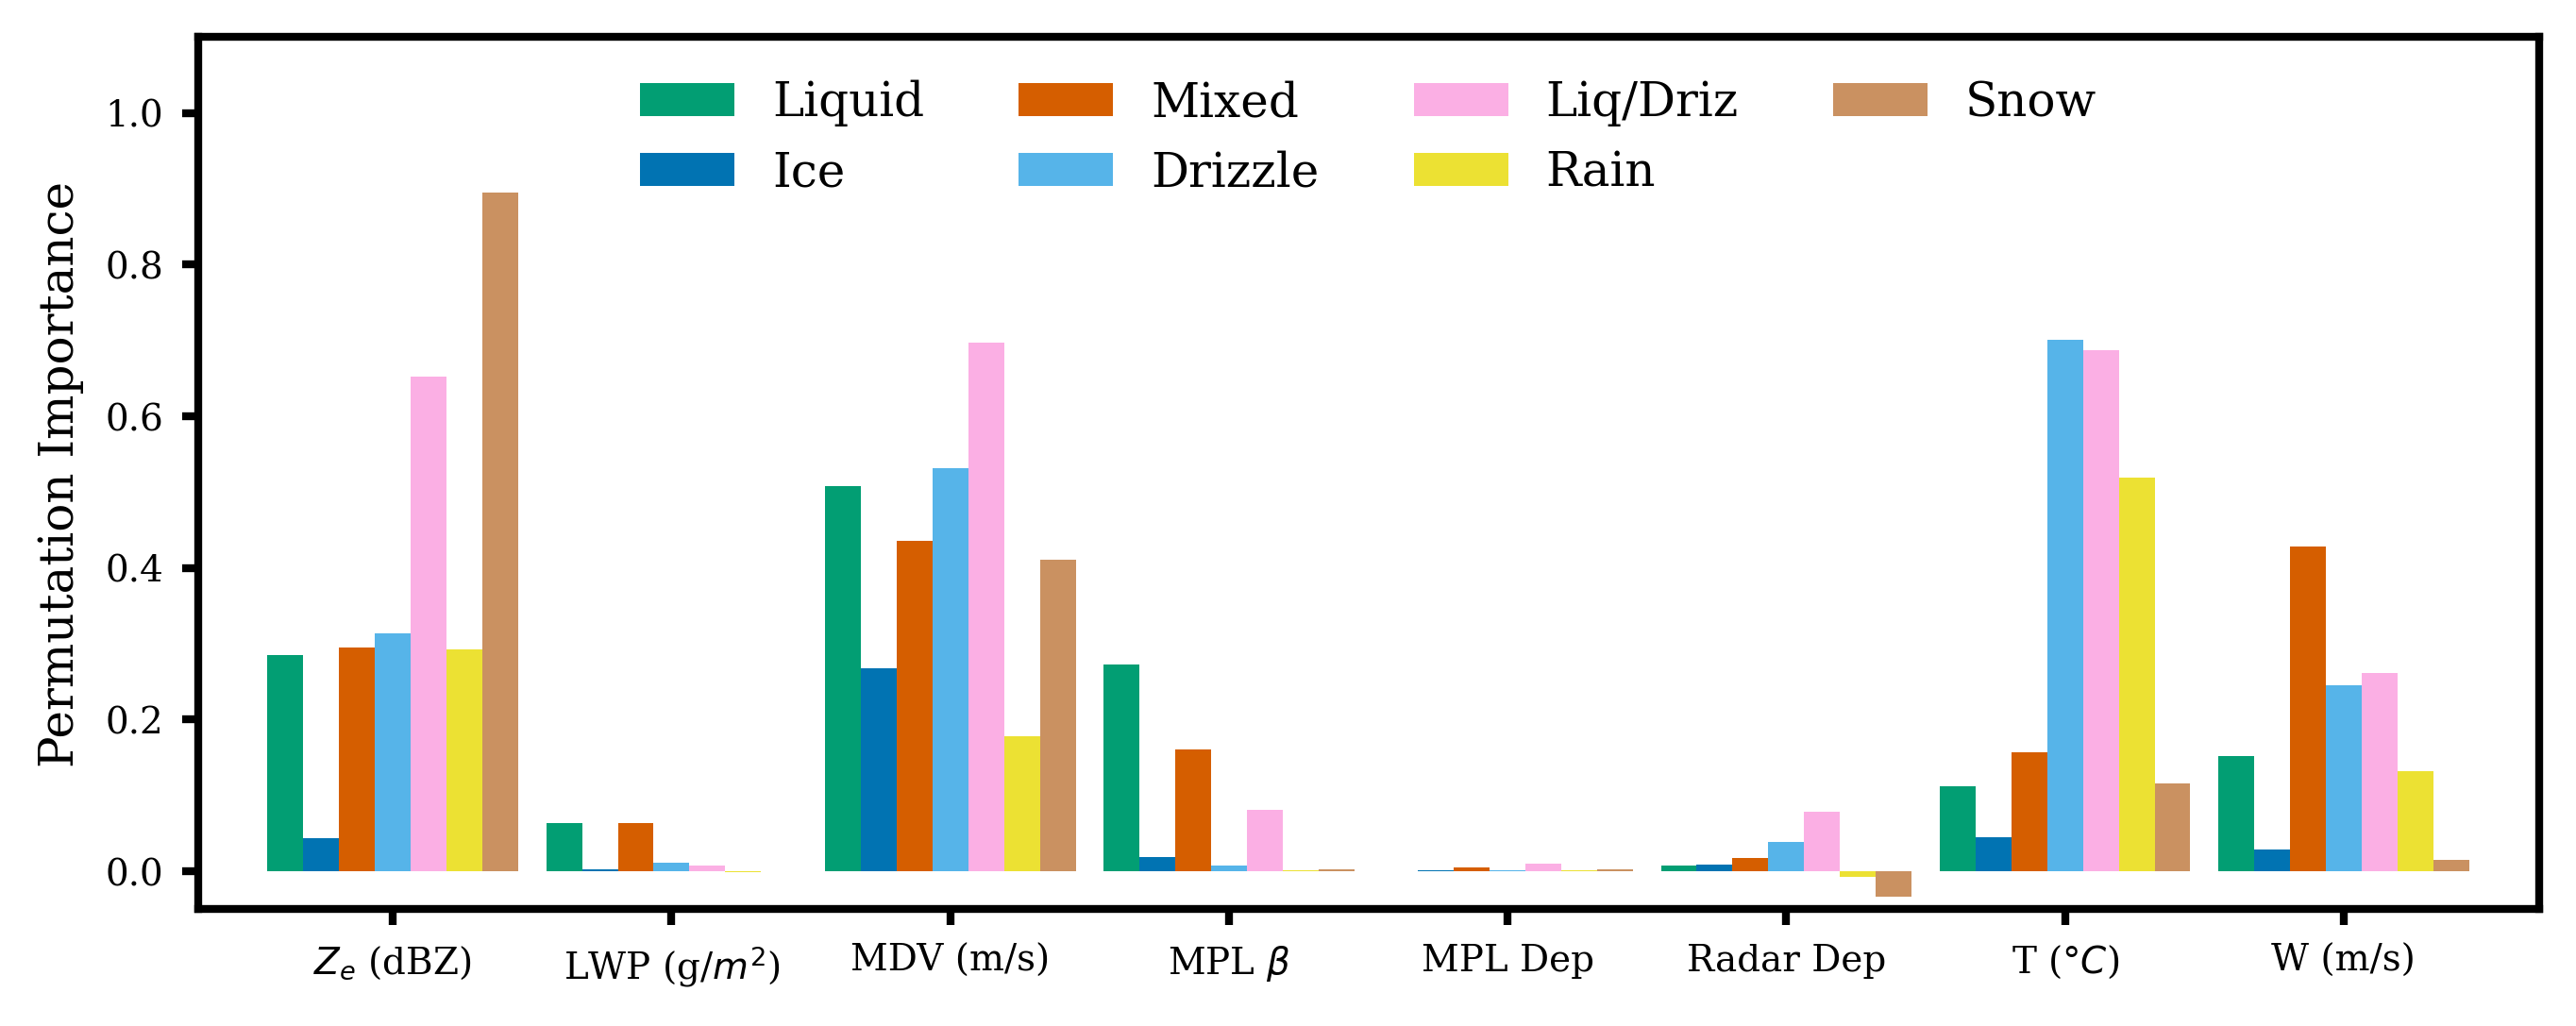

In [50]:
phases = {
    "liquid": "Liquid", 
    "ice": "Ice", 
    "mixed": "Mixed", 
    "drizzle": "Drizzle", 
    "liq_driz": "Liq/Driz", 
    "rain": "Rain", 
    "snow": "Snow",
    # "avg": "Avg",
}
renamed_cmap = {phases[p]: c for p, c in cmap.items() if p in phases}

with plt.style.context("style.mplstyle"):
    fig, ax = plt.subplots(figsize=(8, 3))
    data = df[(df["model"] == "cnnB") & (df["phase"] != "avg")].pivot(index="feature",columns="phase", values="importance")
    data = data[list(phases)].rename(columns=phases)
    data.plot.bar(ax=ax, width=0.9, color=renamed_cmap, legend=None)

    ax.set_ylim(-0.05, 1.1)

    ax.set_xlabel("")
    ax.set_ylabel("Permutation Importance")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

    plt.legend(
        loc="upper center",
        # bbox_to_anchor=(0.5, -0.15),
        ncol=4
    )
    fig.savefig("figures/cnn_importances.png")
    plt.show()